In [18]:
import pandas as pd
import numpy as np
import pickle
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

In [2]:
from sklearn.preprocessing import LabelEncoder

# ▶ 데이터 경로
base_path = '피처_43'

# ▶ train 데이터 불러오기
df = pd.read_csv(f'{base_path}/43_Segment 추가.csv')

# ▶ X, y 분리
X_all = df.drop(columns=['ID', 'Segment'], errors='ignore')
y_all = df['Segment']

# ▶ 레이블 인코딩 (A~E → 0~4)
le = LabelEncoder()
y_all_encoded = le.fit_transform(y_all)

In [3]:
# ▶ stratify로 클래스 비율 유지
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_all_encoded,
    test_size=0.2,
    stratify=y_all_encoded,
    random_state=42
)

In [4]:
import numpy as np

# ▶ AB (A: 0, B: 1)
ab_mask = np.isin(y_train, [0, 1])
X_ab, y_ab = X_train[ab_mask], y_train[ab_mask]

# ▶ CDE (C: 2, D: 3, E: 4)
cde_mask = np.isin(y_train, [2, 3, 4])
X_cde, y_cde = X_train[cde_mask], y_train[cde_mask]

In [14]:
# ▶ AB 모델: 이진 분류 설정
model_ab = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.01,
    depth=4,
    l2_leaf_reg=30,
    loss_function='Logloss',
    task_type='GPU',
    early_stopping_rounds=500,
    random_seed=42,
    verbose=500
)

In [6]:
# ▶ CDE 모델: 다중 클래스
model_cde = CatBoostClassifier(
    iterations=70000,
    learning_rate=0.01,
    depth=5,
    l2_leaf_reg=50,
    loss_function='MultiClass',
    task_type='GPU',
    early_stopping_rounds=15000,
    border_count=64,
    random_seed=42,
    verbose=1000
)

In [22]:
model_ab.fit(X_ab, y_ab, use_best_model=False)
model_cde.fit(X_cde, y_cde, use_best_model=False)

0:	learn: 0.6792379	total: 14.2ms	remaining: 2m 21s
500:	learn: 0.0562626	total: 6.44s	remaining: 2m 2s
1000:	learn: 0.0282429	total: 12.9s	remaining: 1m 56s
1500:	learn: 0.0184055	total: 19.3s	remaining: 1m 49s
2000:	learn: 0.0132856	total: 25.8s	remaining: 1m 43s
2500:	learn: 0.0103020	total: 32.3s	remaining: 1m 36s
3000:	learn: 0.0084453	total: 39.1s	remaining: 1m 31s
3500:	learn: 0.0071131	total: 45.5s	remaining: 1m 24s
4000:	learn: 0.0062076	total: 52.1s	remaining: 1m 18s
4500:	learn: 0.0055109	total: 58.5s	remaining: 1m 11s
5000:	learn: 0.0049336	total: 1m 5s	remaining: 1m 5s
5500:	learn: 0.0044660	total: 1m 11s	remaining: 58.6s
6000:	learn: 0.0041093	total: 1m 18s	remaining: 52.2s
6500:	learn: 0.0037991	total: 1m 25s	remaining: 45.8s
7000:	learn: 0.0035445	total: 1m 31s	remaining: 39.3s
7500:	learn: 0.0033162	total: 1m 38s	remaining: 32.9s
8000:	learn: 0.0031221	total: 1m 45s	remaining: 26.4s
8500:	learn: 0.0029522	total: 1m 52s	remaining: 19.8s
9000:	learn: 0.0028028	total: 1m 

In [23]:
# ▶ AB 확률: [P(A), P(B)]
proba_ab = model_ab.predict_proba(X_valid)  # shape: (n, 2)

# ▶ CDE 확률: [P(C), P(D), P(E)]
proba_cde = model_cde.predict_proba(X_valid)  # shape: (n, 3)

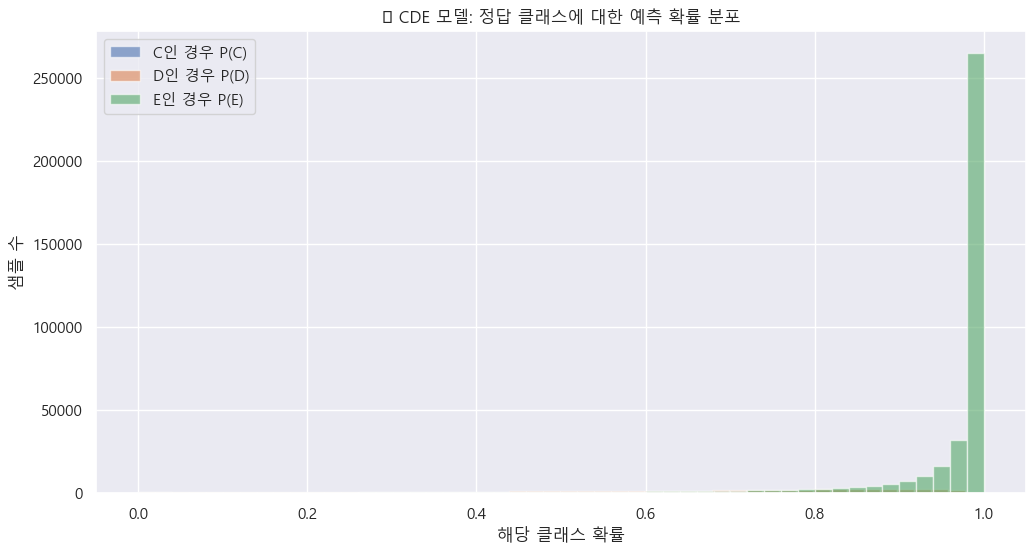

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# CDE 예측 확률 → shape: (n_samples, 3)
# y_valid (0~4) → A:0, B:1, C:2, D:3, E:4

# ▶ CDE 모델에 대해 C,D,E 각각의 정답인 경우 예측 확률 확인
for cls_idx, cls_name in zip([2, 3, 4], ['C', 'D', 'E']):
    true_mask = y_valid == cls_idx
    plt.hist(proba_cde[true_mask, cls_idx - 2], bins=50, alpha=0.6, label=f'{cls_name}인 경우 P({cls_name})')

plt.title("✅ CDE 모델: 정답 클래스에 대한 예측 확률 분포")
plt.xlabel("해당 클래스 확률")
plt.ylabel("샘플 수")
plt.legend()
plt.grid(True)
plt.show()

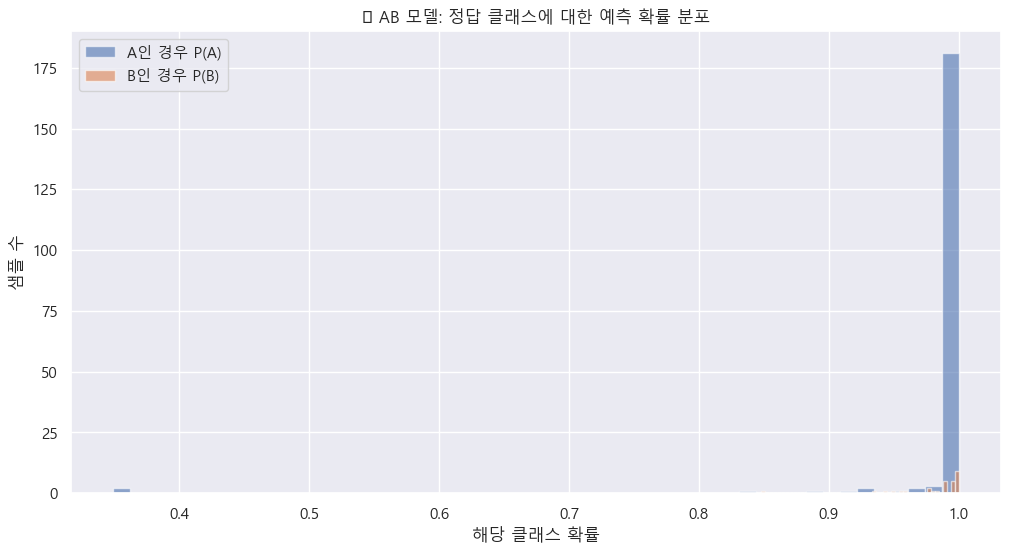

In [25]:
# ▶ AB 모델에 대해 A, B 각각의 정답일 때 예측 확률 확인
for cls_idx, cls_name in zip([0, 1], ['A', 'B']):
    true_mask = y_valid == cls_idx
    plt.hist(proba_ab[true_mask, cls_idx], bins=50, alpha=0.6, label=f'{cls_name}인 경우 P({cls_name})')

plt.title("✅ AB 모델: 정답 클래스에 대한 예측 확률 분포")
plt.xlabel("해당 클래스 확률")
plt.ylabel("샘플 수")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
import numpy as np

# ▶ 최종 예측 확률 배열 생성 (5클래스: A~E)
final_proba = np.zeros((X_valid.shape[0], 5))

threshold = 0.4  # 필요 시 0.05 ~ 0.15 범위 실험

ab_weight = 0.25
cde_weight = 0.75

for i in range(X_valid.shape[0]):
    ab_max = proba_ab[i].max()
    cde_max = proba_cde[i].max()

    if ab_max >= cde_max + threshold:
        final_proba[i, 0:2] = proba_ab[i]
    elif cde_max >= ab_max + threshold:
        final_proba[i, 2:5] = proba_cde[i]
    else:
        # 확률 평균 → AB에 가중치 부여
        final_proba[i, 0:2] = proba_ab[i] * ab_weight
        final_proba[i, 2:5] = proba_cde[i] * cde_weight


# ▶ 최종 예측
y_pred = final_proba.argmax(axis=1)

In [54]:
# F1 및 Classification Report 출력
from sklearn.metrics import f1_score, classification_report

print(f"📌 F1 Micro: {f1_score(y_valid, y_pred, average='micro'):.4f}")
print(f"📌 F1 Macro: {f1_score(y_valid, y_pred, average='macro'):.4f}")
print("\n[📋 Classification Report]")
print(classification_report(y_valid, y_pred, target_names=le.classes_))


📌 F1 Micro: 0.9051
📌 F1 Macro: 0.4741

[📋 Classification Report]
              precision    recall  f1-score   support

           A       0.00      0.04      0.00       194
           B       0.00      0.03      0.00        29
           C       0.79      0.61      0.69     25518
           D       0.78      0.67      0.72     69848
           E       0.96      0.97      0.96    384411

    accuracy                           0.91    480000
   macro avg       0.50      0.46      0.47    480000
weighted avg       0.92      0.91      0.91    480000



In [52]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# 실험할 가중치 및 threshold 조합
ab_weights = [0.2, 0.25, 0.3, 0.35, 0.4]
thresholds = [0.40]

print("📊 AB Weight × Threshold 실험 결과 요약\n")

for threshold in thresholds:
    print(f"\n🔎 [ threshold = {threshold:.2f} ]\n")
    
    for ab_weight in ab_weights:
        cde_weight = 1.0 - ab_weight

        final_proba = np.zeros((X_valid.shape[0], 5))

        for i in range(X_valid.shape[0]):
            ab_max = proba_ab[i].max()
            cde_max = proba_cde[i].max()

            if ab_max >= cde_max + threshold:
                final_proba[i, 0:2] = proba_ab[i]
            elif cde_max >= ab_max + threshold:
                final_proba[i, 2:5] = proba_cde[i]
            else:
                # 평균 가중치 반영
                final_proba[i, 0:2] = proba_ab[i] * ab_weight
                final_proba[i, 2:5] = proba_cde[i] * cde_weight

        # 최종 예측
        y_pred = final_proba.argmax(axis=1)

        # F1 점수 계산
        f1_micro = f1_score(y_valid, y_pred, average='micro')
        f1_macro = f1_score(y_valid, y_pred, average='macro')

        # A/B 클래스 f1 확인
        report = classification_report(y_valid, y_pred, output_dict=True, zero_division=0)
        f1_A = report['0']['f1-score'] if '0' in report else 0.0  # A
        f1_B = report['1']['f1-score'] if '1' in report else 0.0  # B

        print(f"🧪 ab_weight = {ab_weight:.2f} / cde_weight = {cde_weight:.2f} → "
              f"F1_micro: {f1_micro:.4f} | F1_macro: {f1_macro:.4f} | A_f1: {f1_A:.4f} | B_f1: {f1_B:.4f}")

📊 AB Weight × Threshold 실험 결과 요약


🔎 [ threshold = 0.40 ]

🧪 ab_weight = 0.20 / cde_weight = 0.80 → F1_micro: 0.9051 | F1_macro: 0.4741 | A_f1: 0.0023 | B_f1: 0.0004
🧪 ab_weight = 0.25 / cde_weight = 0.75 → F1_micro: 0.9051 | F1_macro: 0.4741 | A_f1: 0.0023 | B_f1: 0.0004
🧪 ab_weight = 0.30 / cde_weight = 0.70 → F1_micro: 0.9051 | F1_macro: 0.4741 | A_f1: 0.0023 | B_f1: 0.0004
🧪 ab_weight = 0.35 / cde_weight = 0.65 → F1_micro: 0.9049 | F1_macro: 0.4740 | A_f1: 0.0023 | B_f1: 0.0004
🧪 ab_weight = 0.40 / cde_weight = 0.60 → F1_micro: 0.8905 | F1_macro: 0.4635 | A_f1: 0.0023 | B_f1: 0.0002
